Using: cuda


100%|██████████| 170M/170M [00:13<00:00, 12.4MB/s]


Epoch 1/20 | Train Acc: 0.166
Epoch 2/20 | Train Acc: 0.229
Epoch 3/20 | Train Acc: 0.266
Epoch 4/20 | Train Acc: 0.289
Epoch 5/20 | Train Acc: 0.322
Epoch 6/20 | Train Acc: 0.346
Epoch 7/20 | Train Acc: 0.360
Epoch 8/20 | Train Acc: 0.369
Epoch 9/20 | Train Acc: 0.383
Epoch 10/20 | Train Acc: 0.391
Epoch 11/20 | Train Acc: 0.403
Epoch 12/20 | Train Acc: 0.419
Epoch 13/20 | Train Acc: 0.427
Epoch 14/20 | Train Acc: 0.439
Epoch 15/20 | Train Acc: 0.442
Epoch 16/20 | Train Acc: 0.457
Epoch 17/20 | Train Acc: 0.466
Epoch 18/20 | Train Acc: 0.471
Epoch 19/20 | Train Acc: 0.478
Epoch 20/20 | Train Acc: 0.491
Saved all feature-learning plots into feature_learning_figs/


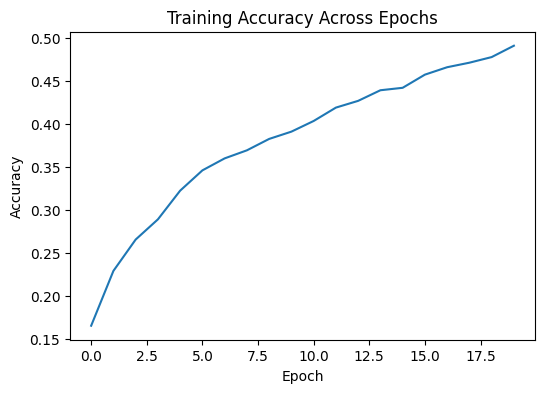

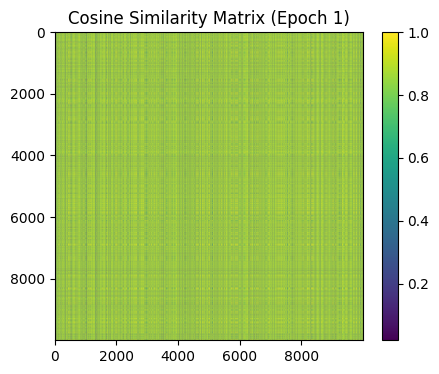

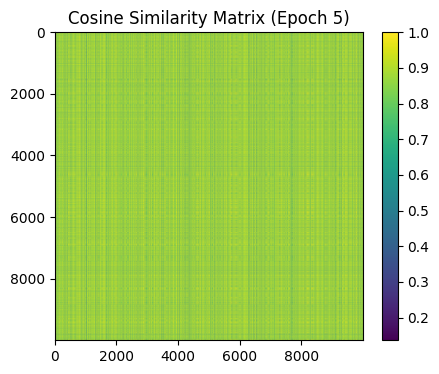

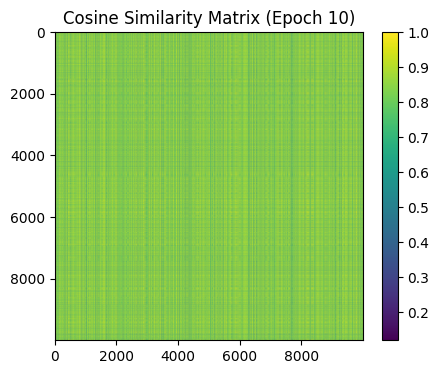

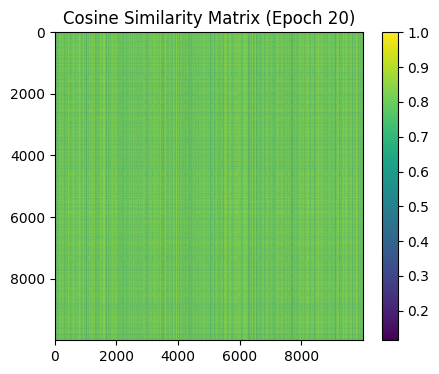

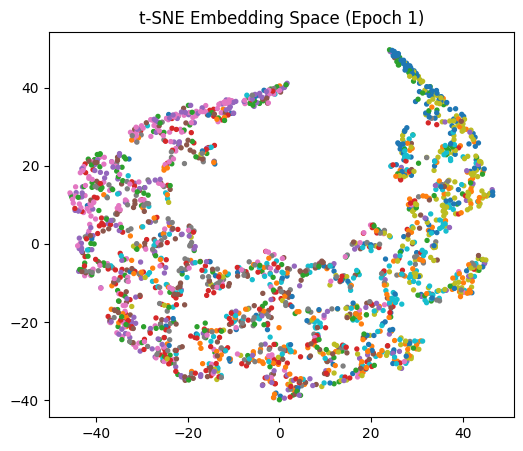

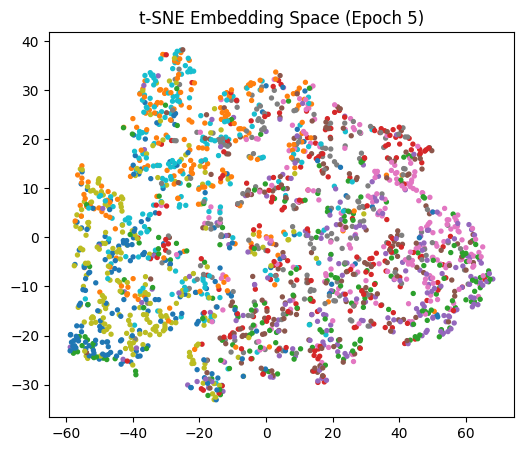

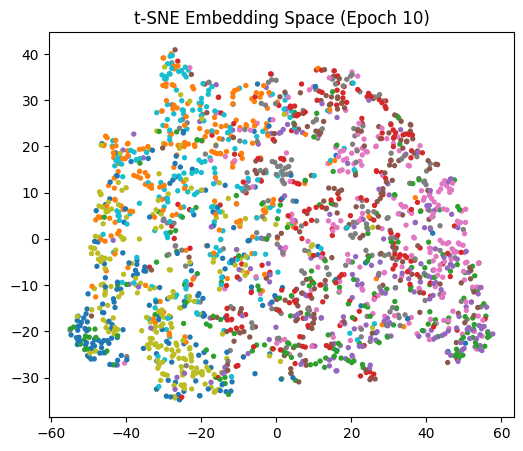

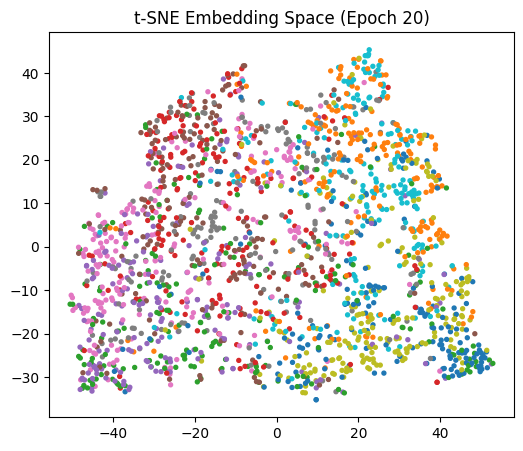

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
from torch.utils.data import DataLoader
import os

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

# ------------------------------
# 1. DATASET
# ------------------------------
transform = T.Compose([
    T.ToTensor(),
    T.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=256, shuffle=True)
testloader = DataLoader(testset, batch_size=1000, shuffle=False)

# ------------------------------
# 2. MODEL (Simple CNN)
# ------------------------------
class SmallCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.fc = nn.Linear(128, 10)

    def forward(self, x, return_features=False):
        x1 = F.relu(self.conv1(x))        # Early features
        x2 = F.relu(self.conv2(x1))       # Mid features
        x3 = F.relu(self.conv3(x2))       # Late features
        gap = x3.mean(dim=[2,3])          # Global Average Pooling
        out = self.fc(gap)
        if return_features:
            return out, x1, x2, gap       # early, mid, late
        return out

model = SmallCNN().to(device)
opt = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.CrossEntropyLoss()

epochs = 20
save_epochs = [1, 5, 10, 20]

embedding_history = {}
layer_similarity = {}

# ------------------------------
# 3. TRAINING LOOP
# ------------------------------
def get_representations(model, loader):
    model.eval()
    all_feats = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            out, early, mid, late = model(x, return_features=True)

            # Flatten spatial layers
            e = early.mean(dim=[2,3]).cpu().numpy()
            m = mid.mean(dim=[2,3]).cpu().numpy()
            l = late.cpu().numpy()

            all_feats.append(l)   # Using late-stage features
            all_labels.append(y.numpy())

    return np.concatenate(all_feats), np.concatenate(all_labels)


def cosine_similarity_matrix(X):
    X = X / np.linalg.norm(X, axis=1, keepdims=True)
    return X @ X.T


loss_curve, acc_curve = [], []

for epoch in range(1, epochs+1):
    model.train()
    total, correct, running_loss = 0, 0, 0

    for x, y in trainloader:
        x, y = x.to(device), y.to(device)
        opt.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        opt.step()

        running_loss += loss.item()
        preds = out.argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

    train_acc = correct/total
    loss_curve.append(running_loss)
    acc_curve.append(train_acc)

    print(f"Epoch {epoch}/{epochs} | Train Acc: {train_acc:.3f}")

    # Save embeddings + similarity matrices at key epochs
    if epoch in save_epochs:
        feats, labels = get_representations(model, testloader)
        embedding_history[epoch] = (feats, labels)
        layer_similarity[epoch] = cosine_similarity_matrix(feats)

# ------------------------------
# 4. VISUALISATIONS
# ------------------------------
os.makedirs("feature_learning_figs", exist_ok=True)

# Learning curve
plt.figure(figsize=(6,4))
plt.plot(acc_curve)
plt.title("Training Accuracy Across Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.savefig("feature_learning_figs/accuracy_curve.png")

# Similarity matrices
for ep in save_epochs:
    sim = layer_similarity[ep]
    plt.figure(figsize=(5,4))
    plt.imshow(sim, cmap="viridis")
    plt.title(f"Cosine Similarity Matrix (Epoch {ep})")
    plt.colorbar()
    plt.savefig(f"feature_learning_figs/similarity_epoch_{ep}.png")

# t-SNE embedding visualisation
for ep in save_epochs:
    feats, labels = embedding_history[ep]
    embedded = TSNE(n_components=2, perplexity=30).fit_transform(feats[:2000])

    plt.figure(figsize=(6,5))
    scatter = plt.scatter(embedded[:,0], embedded[:,1], c=labels[:2000], cmap="tab10", s=8)
    plt.title(f"t-SNE Embedding Space (Epoch {ep})")
    plt.savefig(f"feature_learning_figs/tsne_epoch_{ep}.png")

print("Saved all feature-learning plots into feature_learning_figs/")
